In [1]:
import matplotlib.pyplot as plt # For general plotting

import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Convolutional Neural Network (CNN) for Face Mask Detection

Quick hacky example of putting together a CNN for face mask detection.

Dataset has 14536 samples
(array([0, 1, 2]), array([4000, 3831, 3797], dtype=int64))
(array([0, 1, 2]), array([1000,  958,  950], dtype=int64))
without_mask with_mask without_mask with_mask with_mask incorrect_mask without_mask incorrect_mask


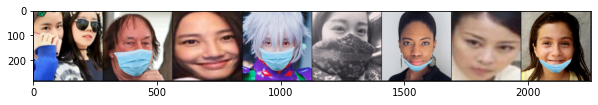

In [2]:
# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([280,280]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.0,0.0,0.0), std=(1.0,1.0,1.0))
    ])

# Specify the batch size for SGD
batch_size = 64
# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
dataset = torchvision.datasets.ImageFolder(root='../../data/FMD_DATASET', transform=transform)
# Specify classes for convenience in printing
classes = ('incorrect_mask', 'with_mask', 'without_mask')
print("Dataset has {} samples".format(len(dataset)))

# List of targets/labels for entire dataset
targets = dataset.targets
# Use sklearn function to split the data into training-test sets (80-20 split)
# Stratified ensures that same percentage of samples of each target class form a complete set
train_idx, test_idx= train_test_split(
    np.arange(len(targets)), test_size=0.2, random_state=random_seed, shuffle=True, stratify=targets)

# Printing the unique class labels in each split set and the number of occurrences per class
print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[test_idx], return_counts=True))

# Create training and test subsets based on split indices
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Plotting stuff ###
fig = plt.figure(figsize=(10,15))
# Utility function to show an image
def imshow(img):
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [3]:
# Note that PyTorch uses NCHW (samples, channels, height, width) image format convention
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_filters, out_classes, kernel_size=3):
        super().__init__()
        # Conv2D layer with 'same' padding so image retains shape
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size, padding='same')
        self.drop = nn.Dropout(p=0.2)
        #self.dropout = 
        # MaxPooling layer with 2x2 kernel size and stride 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, padding='same')
        self.fc1 = nn.Linear(num_filters*2*70*70, num_filters)
        self.fc2 = nn.Linear(num_filters, out_classes)

    def forward(self, x):
        # Non-linear ReLU activations between convolutional layers
        # Conv->ReLU->Pooling
        # 280x280 image -> 140x140 after pooling
        x = self.pool(self.drop(F.relu(self.conv1(x))))
        # 140x140 feature map -> 70x70 after pooling
        x = self.pool(self.drop(F.relu(self.conv2(x))))
        # Flatten all dimensions except batch (start_dim=1)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

input_channels = images.shape[1]
model = ConvNet(input_channels, num_filters=16, out_classes=len(classes))
summary(model, input_size=(input_channels, 280, 280))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 280, 280]             448
           Dropout-2         [-1, 16, 280, 280]               0
         MaxPool2d-3         [-1, 16, 140, 140]               0
            Conv2d-4         [-1, 32, 140, 140]           4,640
           Dropout-5         [-1, 32, 140, 140]               0
         MaxPool2d-6           [-1, 32, 70, 70]               0
            Linear-7                   [-1, 16]       2,508,816
            Linear-8                    [-1, 3]              51
Total params: 2,513,955
Trainable params: 2,513,955
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.90
Forward/backward pass size (MB): 32.30
Params size (MB): 9.59
Estimated Total Size (MB): 42.79
----------------------------------------------------------------


In [4]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            predictions = model(X)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
criterion = nn.CrossEntropyLoss()
num_epochs = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_loader(model, train_dataloader, criterion, optimizer)
    model_test_loader(model, test_dataloader, criterion)

Epoch 1
-------------------------------
loss: 1.091198  [    0/11628]
loss: 1.088423  [  640/11628]
loss: 0.939367  [ 1280/11628]
loss: 0.850926  [ 1920/11628]


C:\Users\mark_\anaconda3\envs\eece5644\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 0.593650  [ 2560/11628]
loss: 0.270592  [ 3200/11628]
loss: 0.463458  [ 3840/11628]
loss: 0.219115  [ 4480/11628]
loss: 0.260913  [ 5120/11628]
loss: 0.132128  [ 5760/11628]
loss: 0.146186  [ 6400/11628]
loss: 0.246899  [ 7040/11628]
loss: 0.115282  [ 7680/11628]
loss: 0.166651  [ 8320/11628]
loss: 0.199135  [ 8960/11628]
loss: 0.242015  [ 9600/11628]
loss: 0.140666  [10240/11628]
loss: 0.180312  [10880/11628]
loss: 0.131786  [11520/11628]
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.221290 



GroundTruth:  without_mask incorrect_mask with_mask with_mask with_mask with_mask without_mask without_mask
Predicted:  without_mask incorrect_mask with_mask with_mask with_mask with_mask without_mask with_mask


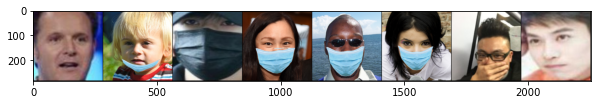

In [5]:
### Plotting stuff ###
fig = plt.figure(figsize=(10,15))

# Get some random test dataset images
dataiter = iter(test_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

outputs = model(images)
# Argmax take the most probable class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))